# LSTM-based classification model

This notebook provides the skelton for defining and training a RNN/LSTM based model for time-series classification. Use this notebook as a reference for PyTorch syntax. If you are `new to PyTorch`, please make sure you understand every line of this notebook `before proceeding` to lab exercises.  
 


In [3]:
## Import torch liberaries to build a neural network model
import torch
from torch import nn
from torch.nn import functional as F

# Graphical tool to illustrate the progress of a loop
from tqdm import tqdm

# numpy for matrix manipulation
import numpy as np

# Matplotlib to plot loss curves
import matplotlib.pyplot as plt

# Our performance metric: Area under the ROC curve
from sklearn.metrics import roc_auc_score

# use-defined file to load and divide data into batches
from get_data import get_training_data,get_validation_data

# Just to supress some non-lethal warnings
import warnings
warnings.filterwarnings('ignore')

### Pytorch model:

- Pytorch models can be defined in using nn.Sequential() module or defining a Model class. We will be using a Model class as it allows us to have a control over flow of the information in neural network. 

- Visit this tutorial for detailed information on defining or building a Pytorch model: http://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

We will now proceed with defining our Model. The Model class inherits `nn.Module` class and must implement two functions:

- A constructor `__init__()` to define the elements such as layers of the model class. When we create an object, this function is automatically called. 
- A `forward()` function: When you run the model, this function is executed. It takes input, passes it through different layers and generates the prediction



In case you are not aware of LSTM layer syntax, please have a look at this: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [4]:
class LSTMClassifier(nn.Module):
    
    ## Define constructor i.e. __init__(). Generally, you can pass different parameters (such as number of hidden units etc.) essential to define the model to this function. 
    ## You can use __init__() to define different layers or modules of the model, as we have done here:  

    def __init__(self, input_dim, hidden_dim, output_dim,device,layer_dim=1):
        super().__init__() ## super is object of the parent class i.e. nn.Module and we are calling __init__() of this paper class. This is mandatory. Why?: You can dig into object oriented programming using python for the answer
        
        ## self means object this class, and it is automatically passed to __init__() when we create an object of the class
        ## Here we are defining different components or fields of our class. These fields can be variables, neural network layers or activation functions.

        self.hidden_dim = hidden_dim 
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Sigmoid()
        self.device=device  # device: cpu or cuda/gpu
    
    def forward(self, x):
        ## This function is called when you pass any input to the model. Here x is our input

        h0, c0 = self.init_hidden(x) ## intialise hidden state and cell state of LSTM to zero.
        ## pass input and intialised cell states to LSTM layer

        out, (hn, cn) = self.rnn(x, (h0, c0)) # Get output from LSTM layer
        
        ## out contains hidden states obtained at each time-step. hn is hidden state obtained after last time-step and cn is the cell state obtained after last step.

        out = self.fc(out[:, -1, :])   # Extract the hidden vector corresponding to last time step

        return self.activation(out) # sigmoid activation as we are dealing with binary classification
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return h0.to(self.device),c0.to(self.device)

### Function to compute validation score

- It recieves model object and validation data and validation labels
- It sels model object to evaluation model using `model.eval()`. We do this to set `dropout` or `batch normalisation` layers to `inference` mode. Though we are not going to use these layers, its a good practice to set model to evaluation model during inference.

In [5]:
def get_validation_score(model,Val_T,Val_L):
    model.eval() # evaluation mode
    tensor_x = torch.Tensor(Val_T).to(model.device) # model data to tensor
    preds=model(tensor_x)[:,0] # pass through the model and obtain predictions

    LOSS=nn.BCELoss().to(device) # Defining a loss function. Its binary cross-entropy loss as we are trying to do binary classification.
    
    val_loss=LOSS(preds,torch.Tensor(Val_L).type(torch.FloatTensor).to(model.device)) # converting labels to tensor as well
    
    return roc_auc_score(Val_L, preds.cpu().detach().numpy()), val_loss  # computing AUROC before returning AUROC and validation loss. roc_auc_Score works on numpy array so we need to convert preds into numpy.

### Function to train the model

- Define an optimiser using `torch.optim`, here we are using SGD 
- Define a loss function, here we are using binary cross entropy
- Pass input batch through model, obtain predictions and compute loss
- Compute gradients by calling `loss.backward()` i.e. differentiate parameters w.r.t. loss 
- Apply gradients using optimiser defined earlier


<b> Neural networks work on batches instead of an example. Hence, Input `x` consists of `B` time-series and is of size `(B,n_time_steps, n_features)`.</b>


In [6]:
def trainer(model,training_set,validation_set,device,lr,epochs=10):
    # Returns a trained model, Training Loss and Validation Loss 
    
    T,L=training_set   # training data and labels
    Val_T,Val_L=validation_set # validation set
    
    # intialise optimiser: It applies the gradient updates to the model weights
    optimizer_model = torch.optim.SGD(model.parameters(),lr,momentum=0.9, nesterov=True) # attach parameters to update with optimiser
 
    # define loss function
    criterion = nn.BCELoss().to(device) ## binary cross entropy
    
    best=0
    
    LOSS=[]
    VAL_LOSS=[]
    
    for epoch in range(0,epochs):
        model.train()
        Loss=0
        for k in range(0,len(T)):
            
            inputs=T[k]
            labels=L[k]
            
            inputs=torch.Tensor(inputs).to(device)                       # make sure inputs and labels are torch tensors and are on same device as model
            labels=torch.Tensor(labels).type(torch.FloatTensor).to(device)
            
            pred=model(inputs)               # obtain predictions 
            
            loss=criterion(pred[:,0],labels) # compute loss
            optimizer_model.zero_grad()     # set existing gradients or noise to zero
            loss.backward()                 # backpropagation, computes gradients of all parameters/weights with respect to loss
            optimizer_model.step()          # Optimiser applies the gradient update
            Loss=Loss+loss
        
        #### compute validation scores after the epoch
        Val_ROC,val_loss=get_validation_score(model,Val_T,Val_L)
        
        VAL_LOSS.append(val_loss.detach().cpu().numpy())
        LOSS.append((Loss/len(T)).detach().cpu().numpy())
        
        print(' Epoch: {:.1f} Training Loss {:.4f} Validation Loss {:.4f} Validation AUC {:.5f}'.format(epoch,LOSS[-1],VAL_LOSS[-1],Val_ROC))
        
        ### if current validation score is better than previous best, save the model
        if best<Val_ROC:
           torch.save(model, './timer-series-classifier') 

    return torch.load('./timer-series-classifier').to(device), LOSS, VAL_LOSS  

### Load data

In [7]:
# get training and validation data

T,L=get_training_data(batch_size=32) # returns lists of training data and label batches
Val_T,Val_L=get_validation_data() # numpy arrays of validation data and labels
print(T[0].shape) # (batch_size,time_steps,n_features)

(33, 48, 59)


### See if GPU is available. If GPU is available, code will run on GPU.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
n_features=T[0].shape[2] # K dimensional vector at each time step
recurrent_units=128 # number of hidden units in  a RNN/LSTM
n_layers=1 # number of stacked LSTM layers
lr=0.001 # learning rate 
n_out=1 # number of output nodes 

### Get model object: call constructor

In [10]:
model=LSTMClassifier(n_features,recurrent_units,n_out,device,n_layers)
model=model.to(device)

In [11]:
model, training_loss, validation_loss=trainer(model,(T,L),(Val_T,Val_L),device,lr,epochs=10)

 Epoch: 0.0 Training Loss 0.5453 Validation Loss 0.4672 Validation AUC 0.69176
 Epoch: 1.0 Training Loss 0.4457 Validation Loss 0.4389 Validation AUC 0.73316
 Epoch: 2.0 Training Loss 0.4286 Validation Loss 0.4277 Validation AUC 0.76297
 Epoch: 3.0 Training Loss 0.4166 Validation Loss 0.4161 Validation AUC 0.78306
 Epoch: 4.0 Training Loss 0.4036 Validation Loss 0.4035 Validation AUC 0.79406
 Epoch: 5.0 Training Loss 0.3898 Validation Loss 0.3908 Validation AUC 0.80047
 Epoch: 6.0 Training Loss 0.3764 Validation Loss 0.3793 Validation AUC 0.80449
 Epoch: 7.0 Training Loss 0.3651 Validation Loss 0.3709 Validation AUC 0.80700
 Epoch: 8.0 Training Loss 0.3572 Validation Loss 0.3662 Validation AUC 0.80861
 Epoch: 9.0 Training Loss 0.3528 Validation Loss 0.3640 Validation AUC 0.80970


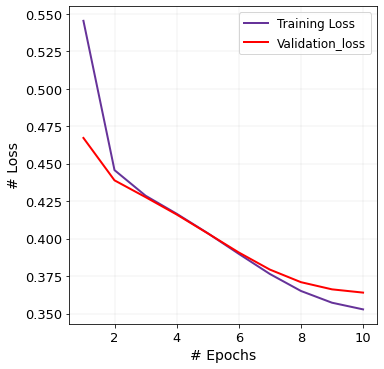

In [12]:
# Plot training and validation loss

fig, ax = plt.subplots(figsize=(5,5))

lw = 2

plt.tight_layout()
ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),training_loss, color='rebeccapurple',
         lw=2, linestyle='-', label='Training Loss')

ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),validation_loss, color='r',
         lw=2, linestyle='-', label='Validation_loss')

ax.set_xlabel('# Epochs',fontsize=14)
ax.set_ylabel('# Loss',fontsize=14)
ax.legend(loc="best",fontsize=12)

ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)


plt.grid(color='gray', linestyle='-', linewidth=0.1)


#plt.savefig('./loss_curves.pdf',dpi=100,bbox_inches='tight')
plt.show()